In [65]:
import numpy as np
import pandas as pd
from PIL import Image
import requests
from io import BytesIO
import urllib.request
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt


In [82]:
# Load data
df = pd.read_csv('MovieGenre.csv', encoding='latin-1').head(1000)
df.drop(columns=['Imdb Link', 'IMDB Score'], inplace=True)
df.dropna(inplace=True)

In [83]:
# Split genres into binary columns
df['Genre'] = df['Genre'].str.split('|')
unique_genres = set().union(*df['Genre'])
for genre in unique_genres:
    df[genre] = df['Genre'].apply(lambda x: 1 if genre in x else 0)
df.drop('Genre', axis=1, inplace=True)


In [84]:
# Drop columns with low value counts
average_count = df.iloc[:, 3:].sum(axis=0).mean()
value_counts = df.iloc[:, 3:].apply(pd.value_counts)
threshold = average_count
columns_to_drop = value_counts.columns[value_counts.min() < threshold]
df.drop(columns=columns_to_drop, inplace=True)


In [85]:
# Function to preprocess image
def preprocess_image(image_path):
    # Open image
    try:
      with urllib.request.urlopen(image_path) as response:
          data = response.read()
          img = Image.open(BytesIO(data))
    except:
        img = Image.open(image_path)

    # Resize to 224x224 pixels
    img = img.resize((224, 224))
    img = img.convert('RGB')

    # Convert image to numpy array
    img_array = np.array(img)
    # Normalize pixel values to [0, 1]
    img_array = img_array / 255.0
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)

    return img_array.flatten()

In [86]:
X = []  # List of preprocessed images

for index, row in df.iterrows():
    image_path = row['Poster']  # 'image_path' contains the file paths of images

    try:
      preprocessed_image = preprocess_image(image_path)
      X.append(preprocessed_image)
    except:
       df.drop(df[df['Poster'] == image_path].index, inplace=True)
       pass


In [87]:
y = df.iloc[:,3:].to_numpy()

print("array denotion")
# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)
print("splitting")
# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

array denotion
splitting


In [92]:
# Initialize and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [73]:
def show(image):
    import matplotlib.pyplot as plt

    # Plot the image using Matplotlib
    plt.imshow(image)
    plt.axis('off')  # Turn off axis
    plt.show()

In [74]:
from PIL import Image
import requests
import numpy as np

def extract_features_from_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))

    # Convert image to RGB mode to ensure it has 3 channels
    img = img.convert('RGB')

    img = img.resize((224, 224))
    img_array = np.array(img)

    # Flatten the image array to create features
    img_features = img_array.flatten()

    # Normalize pixel values to [0, 1]
    img_features = img_features / 255.0

    return img_features


Processing file: https://www.kenosha.com/wp-content/uploads/2023/08/et00072466-jjadjvahwx-landscape-copy.png


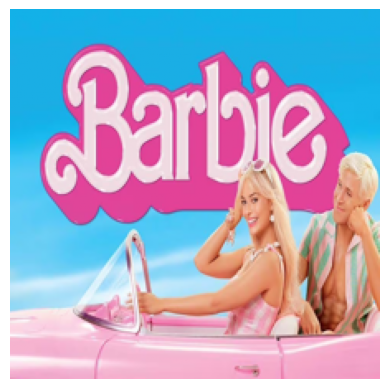

Genres predicted: ['Comedy', 'Drama']
Processing file: https://movies.universalpictures.com/media/opr-tsr1sheet3-look2-rgb-3-1-1-64545c0d15f1e-1.jpg


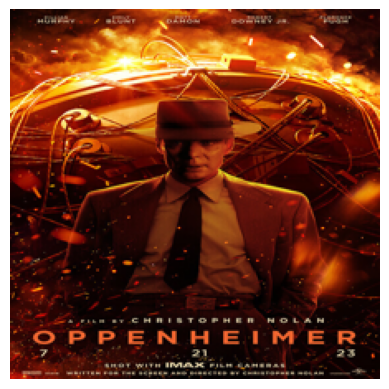

Genres predicted: ['Drama']
Processing file: https://media.themoviedb.org/t/p/w440_and_h660_face/bSMSO9xupd4R4vwTPqigHn2quLN.jpg


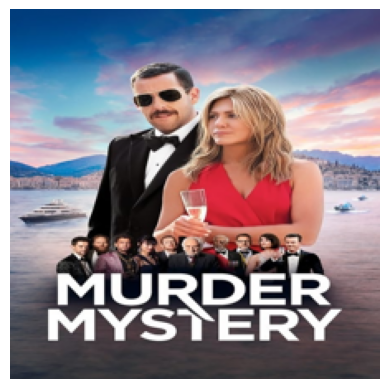

Genres predicted: ['Drama']
Processing file: https://media.timeout.com/images/106027003/1024/576/image.webp


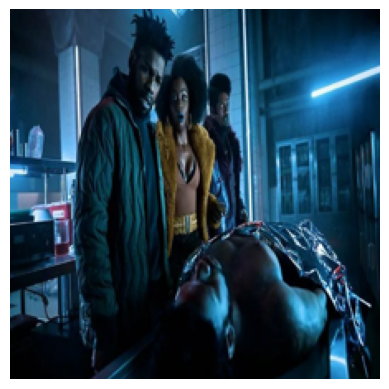

Genres predicted: ['Drama']


In [75]:
# List of file paths
file4=r'https://media.timeout.com/images/106027003/1024/576/image.webp'
file2=r'https://movies.universalpictures.com/media/opr-tsr1sheet3-look2-rgb-3-1-1-64545c0d15f1e-1.jpg'
file1=r'https://www.kenosha.com/wp-content/uploads/2023/08/et00072466-jjadjvahwx-landscape-copy.png'
file3=r'https://media.themoviedb.org/t/p/w440_and_h660_face/bSMSO9xupd4R4vwTPqigHn2quLN.jpg'
file_paths = [file1, file2, file3, file4]  # Add all file paths here

# Iterate over each file path
for file_path in file_paths:
    print("Processing file:", file_path)

    # Preprocess the image
    preprocessed_image = preprocess_image(file_path)
    show(preprocessed_image.reshape(224,224,3))
    try:

        response = requests.get(file_path)
        img = Image.open(BytesIO(response.content))
        img = img.resize((224, 224))
        img = img.convert('RGB')
        img_array = np.array(img)
        img_array = img_array / 255.0
        img_flattened = img_array.flatten()
        prediction = rf_classifier.predict([img_flattened])[0]
        predicted_genres = [genre for i, genre in enumerate(df.columns[3:]) if prediction[i] == 1]
        print(f"Genres predicted: {predicted_genres}")
    except Exception as e:
        print(f"Error processing image {file_path}: {e}")

In [93]:
# Calculate accuracy on validation set
accuracy = rf_classifier.score(X_val, y_val)
print("Validation Accuracy:", accuracy)


Validation Accuracy: 0.16875


Validation Accuracy: 0.1728395061728395


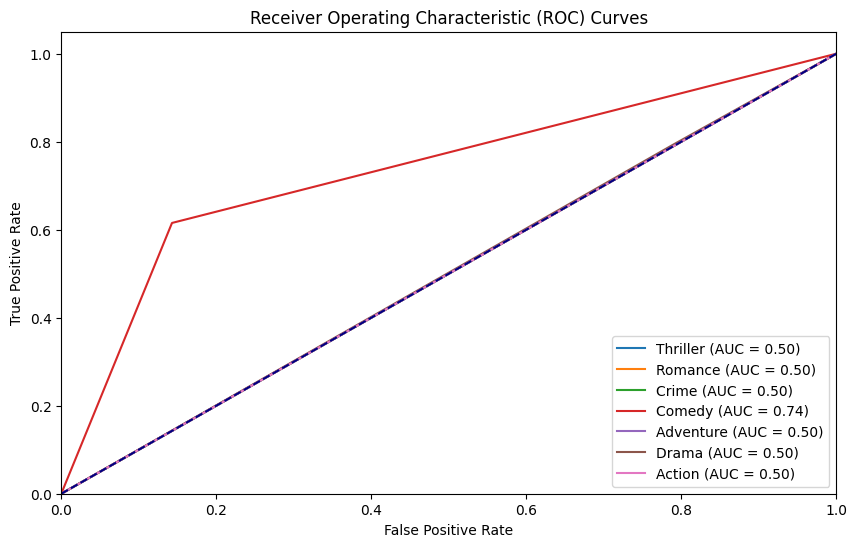

In [77]:
# Make predictions on the validation set
y_pred = rf_classifier.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)
# Plot ROC curves for each genre
plt.figure(figsize=(10, 6))
for i, genre in enumerate(df.columns[3:]):
    fpr, tpr, _ = roc_curve(y_val[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{genre} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

Classification Report:
              precision    recall  f1-score   support

    Thriller       0.00      0.00      0.00        12
     Romance       0.00      0.00      0.00        21
       Crime       0.00      0.00      0.00        12
      Comedy       0.47      0.58      0.52        24
   Adventure       0.00      0.00      0.00         1
       Drama       0.16      0.70      0.25        10
      Action       0.00      0.00      0.00         1

    accuracy                           0.26        81
   macro avg       0.09      0.18      0.11        81
weighted avg       0.16      0.26      0.19        81



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


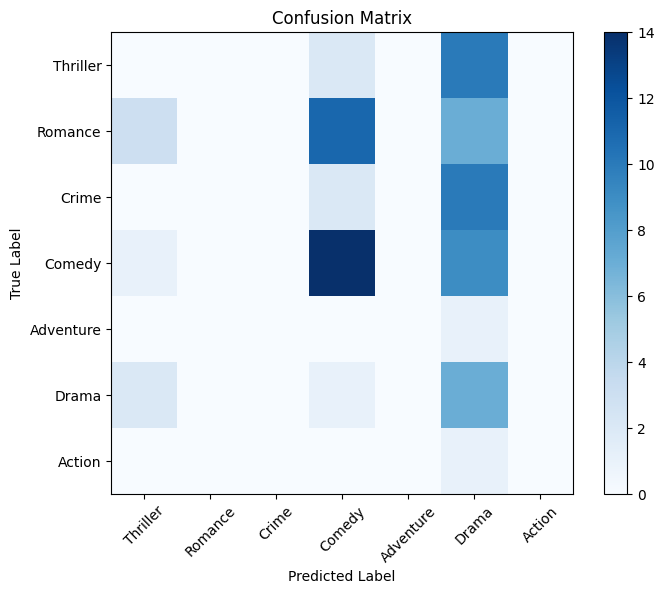

In [78]:
from sklearn.metrics import confusion_matrix, classification_report

# Make predictions on the validation set
y_pred = rf_classifier.predict(X_val)

# Calculate confusion matrix
cm = confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(df.columns[3:]))
plt.xticks(tick_marks, df.columns[3:], rotation=45)
plt.yticks(tick_marks, df.columns[3:])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Print classification report
print("Classification Report:")
print(classification_report(y_val.argmax(axis=1), y_pred.argmax(axis=1), target_names=df.columns[3:]))

plt.show()


In [81]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define parameter distributions for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [None] + list(range(5, 50, 5)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced']
}

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_dist, n_iter=100, cv=3, scoring='accuracy', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# Print best parameters
print("Best Parameters:", random_search.best_params_)

# Use best parameters to initialize Random Forest classifier
best_rf_classifier = random_search.best_estimator_

# Train the model with best parameters
best_rf_classifier.fit(X_train, y_train)

# Make predictions on validation set
y_pred = best_rf_classifier.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy (with best parameters):", accuracy)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best Parameters: {'bootstrap': True, 'class_weight': None, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 7, 'min_samples_split': 10, 'n_estimators': 443}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Validation Accuracy (with best parameters): 0.1728395061728395
